# 随机效应回归树 (Random Effects Regression Trees)

随机效应回归树根据一系列变量（可以是分类变量、顺序变量、连续变量）对连续的因变量划分程度。其优势是构成树模型，直观显示哪个变量更重要



#### 本节课我们将围绕下面例子展开
人们的人格特征、每日行为特点（例如，睡觉时长和质量、感受到的压力、身体活动）和积极情绪是否预测每日的消极情绪？

##### 关键想回答： 哪一个变量对于每日消极情绪区分最好？

##### 我们有这样一套数据：

有 190 个被试，大部分被追踪了完整的8天（日记法）。该数据有以下变量：

Participant ID (id)

Time (e.g., day within the daily diary study; day)

Big Five Inventory: Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism

Sleep hours (slphrs): 被分离成了 trait 和 state

Sleep quality (slpwell): 被分离成了 trait 和 state

Physical activity (lteq): 被分离成了 trait 和 state

Perceived stress (pss)

Positive affect (posaff): 被分离成了 trait 和 state

Negative affect (negaff)

##### 载入数据

In [1]:
amib <- read.csv("C:/Users/77387/Desktop/Data_analysis_courses/R语言与多层线性模型/AMIB.csv")
colnames(amib)

describe(amib) # 该数据中所有的缺失值都已经被去掉了

[1] "X"             "id"            "day"           "bfi_e"        
 [5] "bfi_a"         "bfi_c"         "bfi_n"         "bfi_o"        
 [9] "slphrs"        "slpwell"       "pss"           "lteq"         
[13] "posaff"        "stress"        "posaff_trait"  "slphrs_trait" 
[17] "slpwell_trait" "stress_trait"  "lteq_trait"    "posaff_state" 
[21] "slphrs_state"  "slpwell_state" "stress_state"  "lteq_state"

ERROR: Error in describe(amib): 没有"describe"这个函数


#### 载入函数库

In [2]:
library(psych) # for describing the data
library(plyr) #for data manipulation
library(ggplot2) # for data visualization
library(party) #for tree models
library(partykit) #for tree models
library(rattle) #for tree models
library(REEMtree) #for random effect tree models

Warning message:
"程辑包'psych'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'plyr'是用R版本4.2.3 来建造的"
Warning message:
"程辑包'ggplot2'是用R版本4.2.3 来建造的"

载入程辑包：'ggplot2'


The following objects are masked from 'package:psych':

    %+%, alpha


Warning message:
"程辑包'party'是用R版本4.2.3 来建造的"
载入需要的程辑包：grid

载入需要的程辑包：mvtnorm

Warning message:
"程辑包'mvtnorm'是用R版本4.2.3 来建造的"
载入需要的程辑包：modeltools

载入需要的程辑包：stats4


载入程辑包：'modeltools'


The following object is masked from 'package:plyr':

    empty


载入需要的程辑包：strucchange

Warning message:
"程辑包'strucchange'是用R版本4.2.2 来建造的"
载入需要的程辑包：zoo

Warning message:
"程辑包'zoo'是用R版本4.2.3 来建造的"

载入程辑包：'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


载入需要的程辑包：sandwich

Warning message:
"程辑包'partykit'是用R版本4.2.3 来建造的"
载入需要的程辑包：libcoin

Warning message:
"程辑包'libcoin'是用R版本4.2.3 来建造的"

载入程辑包：'partykit'


The following objects are masked from 'package:party':

    cforest, ctree, ctree_control, edge_simple, mob, mob_control,
    node_barplot,

#### 建模前我们先可视化一下我们的数据：

首先我们先看一下所有人积极情绪7天的变化

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


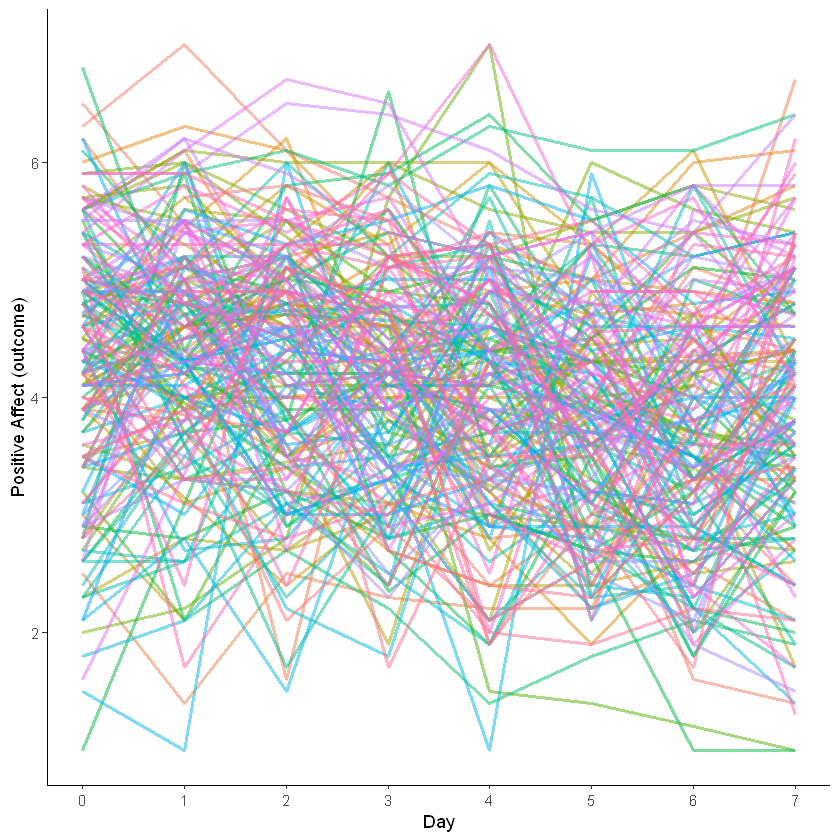

In [3]:
ggplot(data = amib, 
       aes(x = day, group = id, color = factor(id), legend = FALSE)) +
  geom_line(aes(x = day, y = posaff), lty = 1, size = 1, alpha = .5) +
  xlab("Day") + 
  ylab("Positive Affect (outcome)") + 
  scale_x_continuous(breaks=seq(0,7,by=1)) +
  theme_classic() +
  theme(legend.position = "none")

#### 个体间因素（neuroticism）对每日积极情绪的影响

`geom_smooth()` using formula = 'y ~ x'


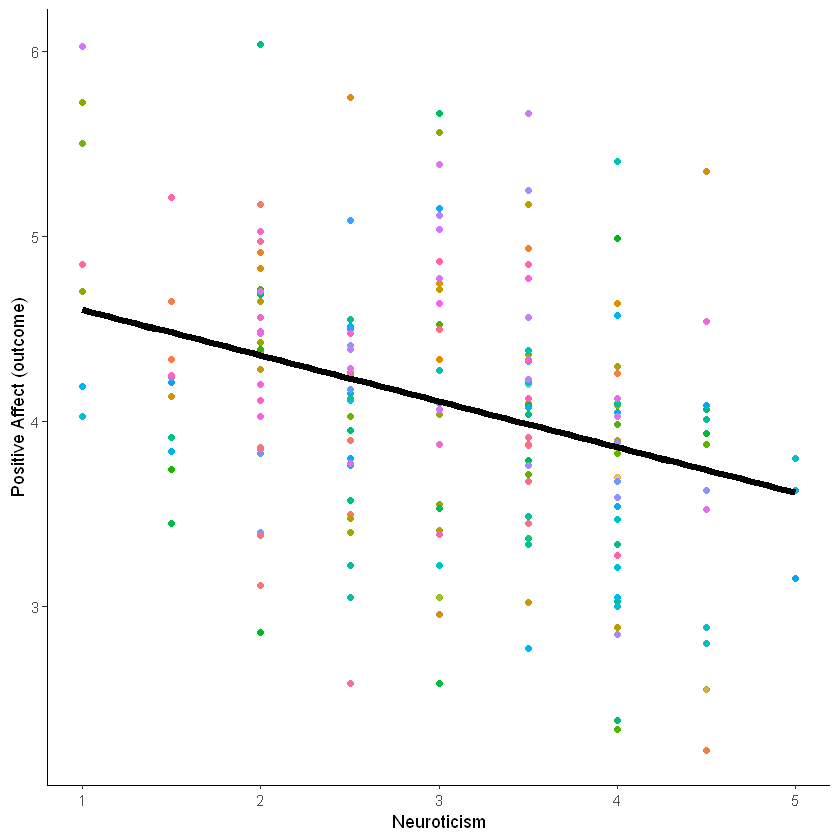

In [4]:
ggplot(data = amib,  
       aes(x = bfi_n, y = posaff_trait,
           group = id, color = factor(id), legend = FALSE)) +
  geom_point(alpha = .5) +
  geom_smooth(aes(group=1), method=lm, se=FALSE, fullrange=TRUE, lty=1, size=2, color="black") +
  xlab("Neuroticism") + 
  ylab("Positive Affect (outcome)") + 
  theme_classic() +
  theme(legend.position = "none")

#### 个体间因素（sleep hour trait）对每日积极情绪的影响

`geom_smooth()` using formula = 'y ~ x'


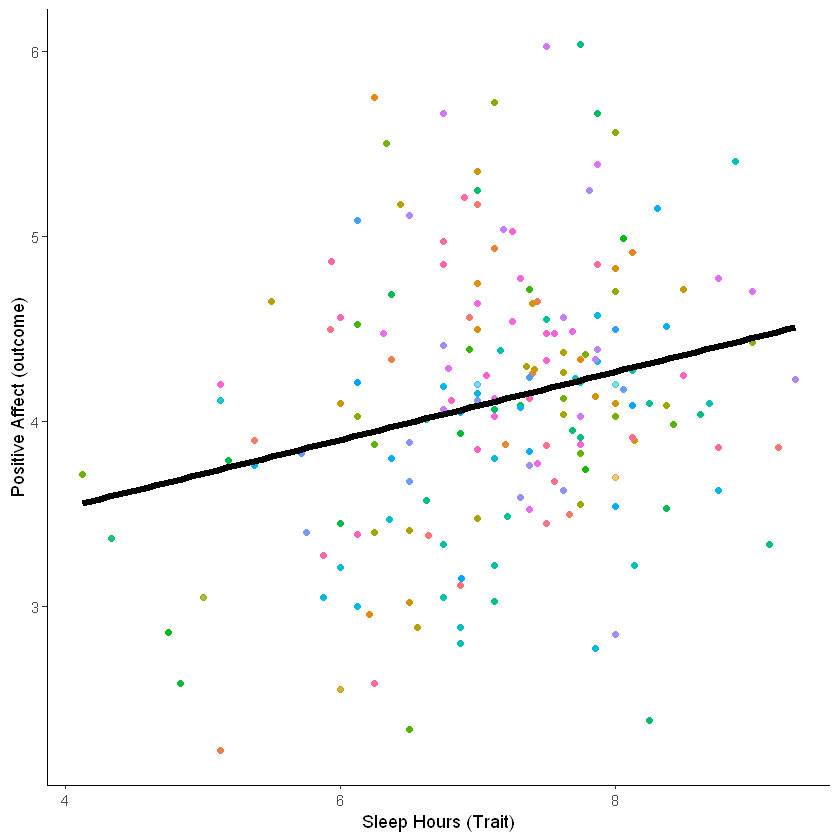

In [5]:
ggplot(data = amib, #subset(amib, id <= 120), 
       aes(x = slphrs_trait, y = posaff_trait,
           group = id, color = factor(id), legend = FALSE)) +
  geom_point(alpha = .5) +
  geom_smooth(aes(group=1), method=lm, se=FALSE, fullrange=TRUE, lty=1, size=2, color="black") +
  xlab("Sleep Hours (Trait)") + 
  ylab("Positive Affect (outcome)") + 
  theme_classic() +
  theme(legend.position = "none")

#### 个体内因素（state stress）对个每日积极情绪的影响

`geom_smooth()` using formula = 'y ~ x'


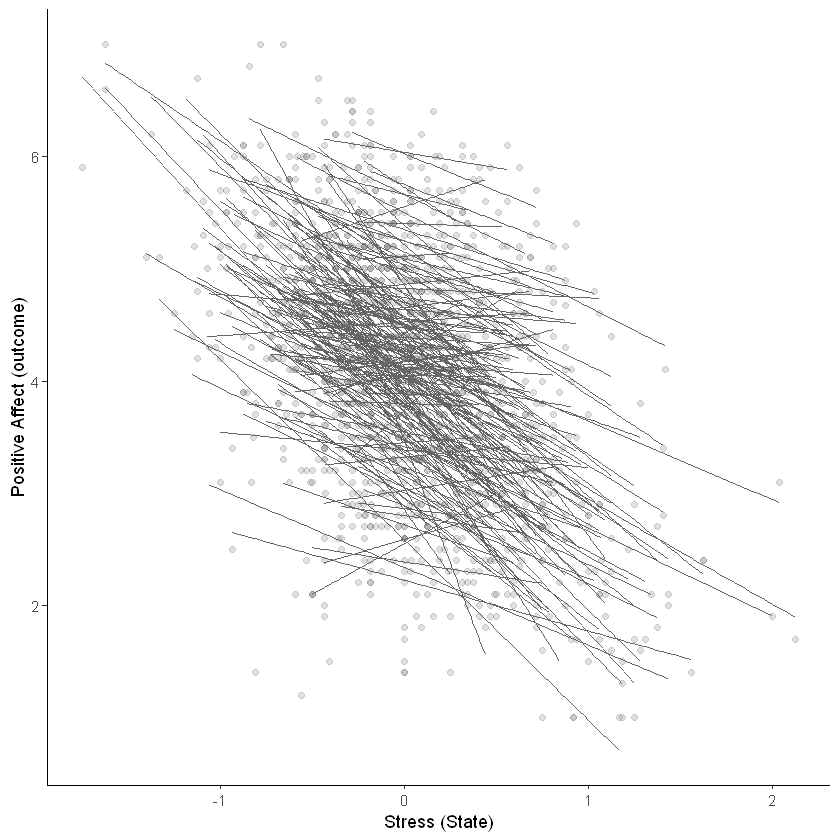

In [6]:
#time-varying predictor
ggplot(data = amib, 
       aes(x = stress_state, y = posaff,
           group = id, color = factor(id), legend = FALSE)) +
  geom_point(color="gray40",alpha = .2) +
  geom_smooth(method=lm, se=FALSE, fullrange=FALSE, lty=1, size=.5, color="gray40") +
  #geom_smooth(aes(group=1), method=loess, se=FALSE, fullrange=FALSE, lty=1, size=2, color="blue") +
  xlab("Stress (State)") + 
  ylab("Positive Affect (outcome)") + 
  theme_classic() +
  theme(legend.position = "none")

#### 个体内因素（physical activity state）对每日积极情绪的影响

`geom_smooth()` using formula = 'y ~ x'


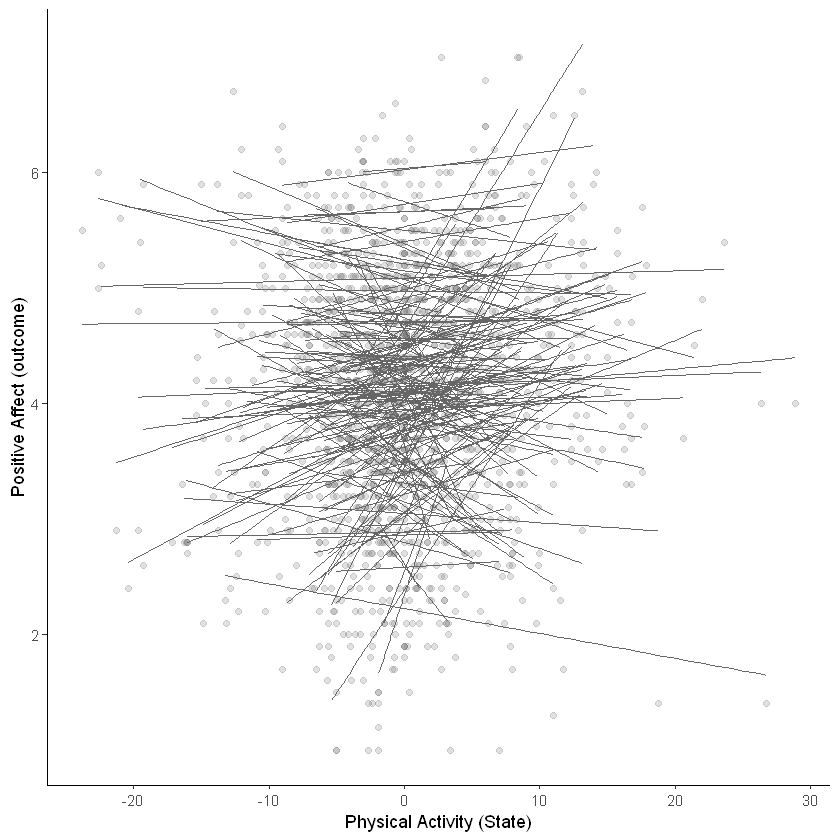

In [7]:
#time-varying predictor
ggplot(data = amib, 
       aes(x = lteq_state, y = posaff,
           group = id, color = factor(id), legend = FALSE)) +
  geom_point(color="gray40",alpha = .2) +
  geom_smooth(method=lm, se=FALSE, fullrange=FALSE, lty=1, size=.5, color="gray40") +
  #geom_smooth(aes(group=1), method=loess, se=FALSE, fullrange=FALSE, lty=1, size=2, color="blue") +
  xlab("Physical Activity (State)") + 
  ylab("Positive Affect (outcome)") + 
  theme_classic() +
  theme(legend.position = "none")

### 随机效应回归树模型（Random Effects Regression Tree Model）

In [8]:
#setting seed for replication
set.seed(1234)

# 拟合树模型
model_tree1 <- REEMtree(posaff ~ day + bfi_a + bfi_c + bfi_n + bfi_o + 
                              slphrs_trait +  slpwell_trait + stress_trait + lteq_trait +
                              slphrs_state +  slpwell_state + stress_state + lteq_state, 
                       data = amib, 
                       random = ~ 1 | id)



In [9]:
print(model_tree1)

[1] "*** RE-EM Tree ***"
n= 1406 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 1406 1165.94800 4.105277  
   2) stress_state>=0.3333333 319  264.24670 3.378714  
     4) stress_state>=0.9114583 56   36.58085 2.599828 *
     5) stress_state< 0.9114583 263  179.41080 3.558184  
      10) stress_trait>=1.432292 131   66.96483 3.332668 *
      11) stress_trait< 1.432292 132   89.09902 3.762530 *
   3) stress_state< 0.3333333 1087  683.88340 4.318500  
     6) slpwell_trait< 3.1875 950  573.27710 4.228651  
      12) stress_state>=-0.4508929 755  394.14010 4.106730  
        24) slpwell_trait< 1.5625 83   32.07521 3.681534 *
        25) slpwell_trait>=1.5625 672  324.48450 4.185138  
          50) day>=2.5 430  186.35070 4.001632 *
          51) day< 2.5 242  112.94760 4.420614 *
      13) stress_state< -0.4508929 195  124.46070 4.749160 *
     7) slpwell_trait>=3.1875 137   49.75638 4.847015 *
[1] "Estimated covariance matrix of random effects:"
            (Int

In [10]:
# 计算AIC和BIC结果
AIC(model_tree1)

[1] 3410.981

In [11]:
BIC(model_tree1)

[1] 3463.409

#### 我们将上述模型可视化出来，可以帮助我们更好的解读

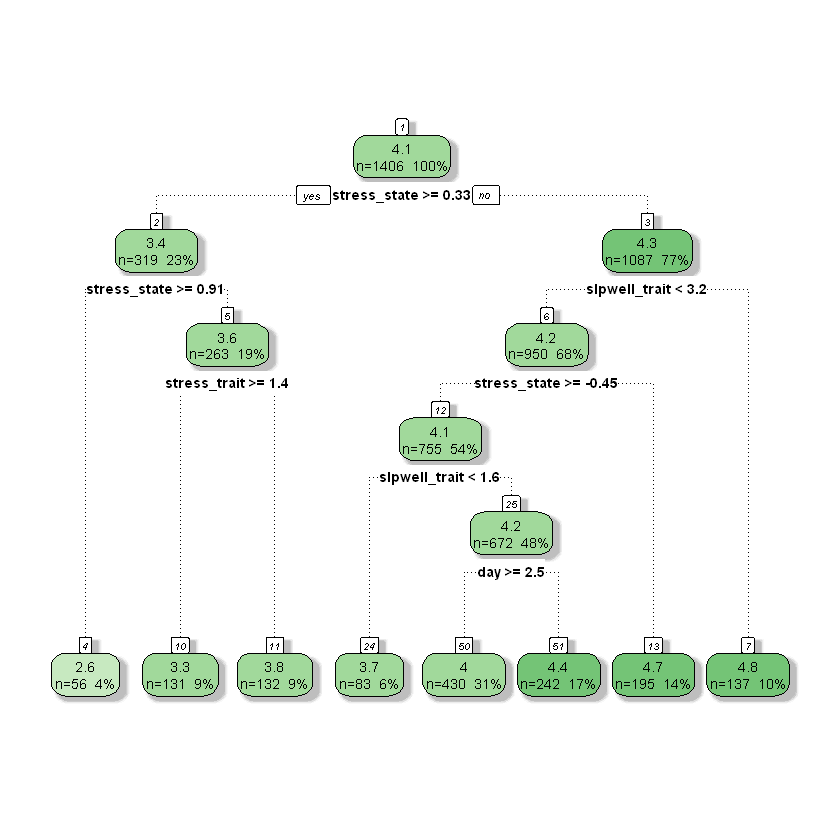

In [12]:
# Plot model object after making into a tree usign tree()
fancyRpartPlot(tree(model_tree1),
               digits = 2,
               sub="",
               main="")

#### 上述结果说明，stress_state , day , slpwell_trait 对每日积极情绪有预测作用。
#### 接下来我们拟合此树模型

In [13]:
model_tree2 <- REEMtree(posaff ~ day + bfi_a + bfi_c + bfi_n + bfi_o + 
                              slphrs_trait +  slpwell_trait + stress_trait + lteq_trait +
                              slphrs_state +  slpwell_state + stress_state + lteq_state, 
                       data = amib, 
                       tree.control = rpart.control(cp = .8),
                       random = ~ 1 | id) #correlation=corAR1())

# Print statistical output
print(model_tree2)

[1] "*** RE-EM Tree ***"
n= 1406 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 1406 1147.77200 4.104789  
   2) stress_state>=0.3333333 319  256.71460 3.378654  
     4) stress_state>=0.9114583 56   34.98793 2.624208 *
     5) stress_state< 0.9114583 263  175.78370 3.553771  
      10) stress_trait>=1.432292 131   67.85374 3.331501 *
      11) stress_trait< 1.432292 132   84.91609 3.783043 *
   3) stress_state< 0.3333333 1087  673.49570 4.317887  
     6) slpwell_trait< 3.1875 950  563.33710 4.227216  
      12) stress_state>=-0.2395833 557  278.20510 4.023128  
        24) slpwell_trait< 1.5625 63   24.88306 3.623117 *
        25) slpwell_trait>=1.5625 494  230.01870 4.096173  
          50) day>=4.5 184   71.53211 3.800641 *
          51) day< 4.5 310  139.01430 4.224247 *
      13) stress_state< -0.2395833 393  229.05060 4.516469  
        26) stress_state>=-0.6160714 287  144.08130 4.377661  
          52) slpwell_trait< 1.464286 23   14.27499 3.709992 *

In [14]:
# Print fit statistics,AIC and BIC, for the model
AIC(model_tree2)

[1] 3385.775

In [15]:
BIC(model_tree2)

[1] 3448.672

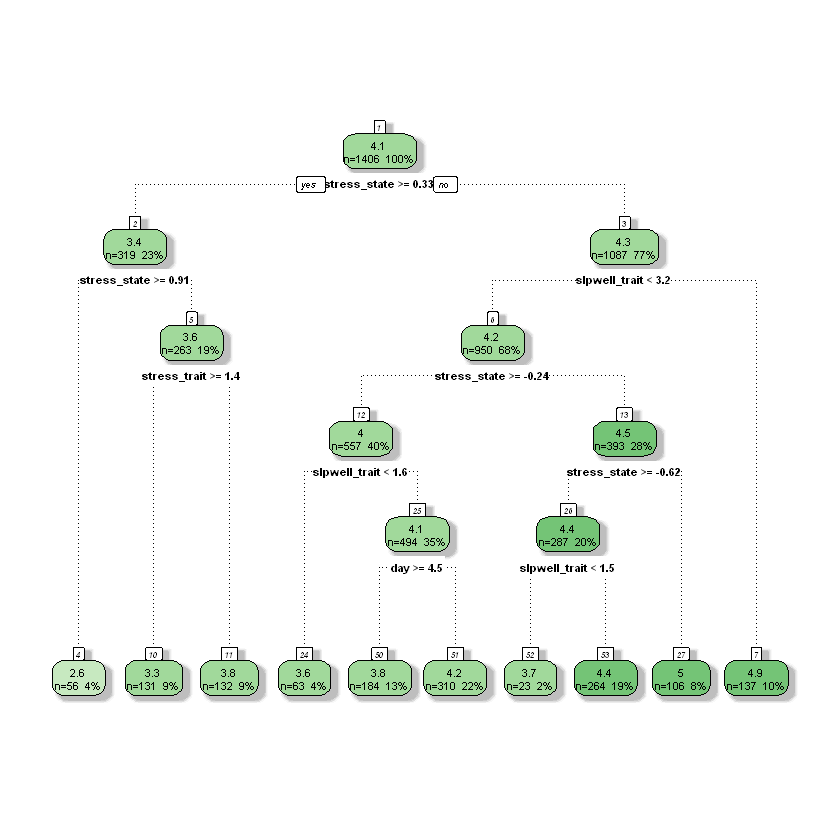

In [16]:
# Plot tree
fancyRpartPlot(tree(model_tree2),
               digits = 2,
               sub="",
               main="")

## 模型评价

分割训练集和测试集

In [22]:
# 选择数据集中 80% 的数据
set.seed(1234)
# 新的训练数据集的id
ids_train <- sample(unique(amib$id), size=20)
# 提取训练数据集
train_amib <- amib[amib$id %in% ids_train, ]

In [23]:
# 估计树模型
set.seed(1267)
model_tree1cv <- REEMtree(posaff ~ day + bfi_a + bfi_c + bfi_n + bfi_o + 
                              slphrs_trait +  slpwell_trait + stress_trait + lteq_trait +
                              slphrs_state +  slpwell_state + stress_state + lteq_state,
                          data = train_amib, 
                          tree.control = rpart.control(cp = 0.01),
                          random = ~ 1 | id)

In [25]:
# 估计预测结果
amib$posaff_predict1 <- predict(model_tree1cv, amib, EstimateRandomEffects = FALSE)

In [29]:
head(amib)

,X,id,day,bfi_e,bfi_a,bfi_c,bfi_n,bfi_o,slphrs,slpwell,...,slpwell_trait,stress_trait,lteq_trait,posaff_state,slphrs_state,slpwell_state,stress_state,lteq_state,posaff_predict1,posaff_sqresidual1
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,101,0,3.5,1.5,4,2,4,6.0,1,...,2.75,1.0625,13.875,-0.6625,-0.9375,-1.75,0.4375,-3.875,4.015606,0.01336479
2,2,101,1,3.5,1.5,4,2,4,2.0,1,...,2.75,1.0625,13.875,-0.7625,-4.9375,-1.75,0.1875,-3.875,4.015606,0.04648603
3,3,101,2,3.5,1.5,4,2,4,9.0,3,...,2.75,1.0625,13.875,0.5375,2.0625,0.25,-0.5625,-3.875,4.754971,0.11904486
4,4,101,3,3.5,1.5,4,2,4,7.5,3,...,2.75,1.0625,13.875,1.0375,0.5625,0.25,-0.0625,-4.875,4.015606,2.51030377
5,5,101,4,3.5,1.5,4,2,4,8.0,4,...,2.75,1.0625,13.875,-0.2625,1.0625,1.25,0.1875,4.125,4.015606,0.08087984
6,6,101,5,3.5,1.5,4,2,4,8.0,3,...,2.75,1.0625,13.875,-0.6625,1.0625,0.25,0.1875,5.125,4.015606,0.01336479


#### 计算测试集和训练集的squared residual

In [30]:
# 实际结果与预测结果的差异（平方）
head(amib$posaff_predict1)
head(amib$posaff)

amib$posaff_sqresidual1 <- (amib$posaff_predict1 - amib$posaff) ^2

[1] 4.015606 4.015606 4.754971 4.015606 4.015606 4.015606

[1] 3.9 3.8 5.1 5.6 4.3 3.9

In [27]:
# 训练数据与实际数据的差异
sqresidual_inside <- amib[amib$id %in% ids_train, c("posaff_sqresidual1") ] 

# 测试数据集与实际数据的差异
sqresidual_outside <- amib[!c(amib$id %in% ids_train), c("posaff_sqresidual1")]

sqresidual_inside
sqresidual_outside

[1] 3.045125448 2.610183340 1.031455920 0.512092210 2.610183340 0.003173255
  [7] 0.198050616 0.416062129 0.020640594 3.084700872 0.024016079 1.031455920
 [13] 7.048872172 0.020640594 0.059374264 0.024439585 0.059374264 0.001906925
 [19] 0.118107933 0.196841603 0.020640594 4.182142717 0.147758606 3.184061293
 [25] 3.550940056 5.685333873 0.555067885 1.092085154 0.468394896 1.112964272
 [31] 0.002027591 0.234637370 0.265849736 0.099607263 0.000243553 0.172728500
 [37] 0.265849736 1.916546240 0.172728500 5.362031996 0.838334683 0.307993053
 [43] 1.333958516 2.417935491 4.475789523 0.378970973 0.198050616 1.402788713
 [49] 0.065010322 0.024016079 0.307993053 1.477698393 0.080879843 1.839635550
 [55] 0.003021835 0.002027591 3.084700872 0.198050616 0.572037568 0.020640594
 [61] 0.003021835 0.206998810 0.208238577 0.001906925 0.198050616 0.080879843
 [67] 0.234637370 0.034001080 0.265849736 0.468394896 0.065010322 0.099607263
 [73] 2.382911969 4.176580317 1.550096667 4.176580317 1.311090910 1.333958516
 [79] 3.827233533 0.428987297 0.007122316 0.341516133 1.477698393 1.175909950
 [85] 3.669547050 0.099607263 0.034001080 0.021033347 1.402788713 0.065010322
 [91] 0.002027591 1.244577156 0.665213446 0.013364790 0.234637370 0.013364790
 [97] 0.265849736 0.147758606 0.341516133 0.046486026 0.099607263 0.378970973
[103] 0.057891335 1.244577156 0.060039104 0.172728500 2.297062103 0.512092210
[109] 1.333958516 0.046486026 0.080879843 0.208238577 0.733303898 0.024439585
[115] 0.553042612 0.126972246 0.003173255 1.307977290 2.382911969 2.837182530
[121] 1.916546240 1.175909950 0.615273660 1.402788713 0.034001080 0.969031186
[127] 0.021033347 1.916546240 4.344697583 3.783136961 3.045125448 0.969031186
[133] 2.003940866 2.510303766 0.198050616 1.649667476 0.024016079 1.649667476
[139] 0.714073641 0.099607263 0.569981541 0.512092210 0.000243553

[1]  0.013364790  0.046486026  0.119044860  2.510303766  0.080879843
   [6]  0.013364790  0.119044860  0.615273660  5.218455110  5.040154229
  [11]  1.809102423  0.297056373  0.003021835  4.062668286  0.969031186
  [16]  0.341516133  0.468394896  1.112964272  5.835153233  6.841395706
  [21]  2.743434541  1.839635550  0.119044860  0.428987297  0.059374264
  [26]  0.020640594  1.839635550  1.337102889  2.088108179  0.060039104
  [31]  5.835153233  1.402788713  0.002027591  0.172728500  0.007122316
  [36]  3.783136961  0.007122316  0.341516133  0.007122316  0.512092210
  [41]  0.080879843  0.297056373  0.341516133  0.126004566  5.084895197
  [46]  6.841395706  2.297062103  2.943304576  3.296425813  3.296425813
  [51]  4.643900953  3.669547050  0.024016079  0.198050616  0.024439585
  [56]  0.711776281  0.569981541  2.510303766  1.809102423  0.468394896
  [61]  0.147758606  0.416062129  0.297056373  0.065010322  0.265849736
  [66]  3.084700872  0.730975785  1.115836559  0.208238577  0.118107933
  [71]  0.099607263  0.341516133  0.468394896  1.402788713  0.782152423
  [76]  0.969031186  1.916546240  3.184061293  3.937818820  5.218455110
  [81]  4.344697583  1.402788713  1.649667476  0.969031186  3.937818820
  [86]  4.344697583  0.099607263  0.434800205  2.088108179  0.569981541
  [91]  0.007122316  0.080879843  0.341516133  0.002027591  0.341516133
  [96]  0.782152423  0.003021835  0.615273660  0.512092210  0.013364790
 [101]  2.610183340  0.838334683  1.477698393  4.475789523  1.477698393
 [106]  0.911970028  0.341516133  0.060039104  1.402788713  0.003021835
 [111]  0.147758606  0.060039104  0.021033347  0.615273660  0.013364790
 [116]  0.341516133  0.782152423  0.046486026  0.206998810  0.147758606
 [121]  1.337102889  0.914570229  1.574952759  1.115836559  1.578369220
 [126]  1.578369220  0.002027591  1.477698393  0.000243553  0.000243553
 [131]  0.000243553  0.000243553  0.000243553  0.065010322  0.782152423
 [136]  1.175909950  1.092085154  1.649667476  3.937818820  0.297056373
 [141]  1.809102423  0.080879843  0.013364790  0.297056373  1.550096667
 [146]  0.265849736  0.234637370  1.337102889  0.003173255  1.835947003
 [151]  0.118107933  0.414308942  5.545889440  0.196841603  0.126972246
 [156]  0.378970973  0.065010322  0.003021835  0.024016079  1.244577156
 [161]  0.080879843  0.080879843  0.234637370  0.307993053  0.782152423
 [166]  0.046486026  0.665213446  1.175909950  0.615273660  1.175909950
 [171]  0.341516133  0.341516133  0.147758606  0.065010322  0.969031186
 [176]  2.837182530  0.060039104  1.550096667  1.550096667  0.512092210
 [181]  0.234637370  2.120901881  0.714073641  6.033565185  1.839635550
 [186]  1.839635550  0.914570229  0.430771237  4.228499863  2.943304576
 [191]  1.477698393  1.730819630  1.031455920  0.013364790  0.512092210
 [196]  2.297062103  2.003940866  1.092085154  0.615273660  0.003021835
 [201]  0.665213446  2.610183340  0.034001080  0.147758606  0.007122316
 [206]  0.080879843  0.172728500  4.475789523  0.024016079  0.730975785
 [211]  1.112964272  5.362031996  0.730975785  0.034001080  1.175909950
 [216]  0.080879843  0.265849736  0.147758606  0.172728500  0.119044860
 [221]  0.265849736  0.099607263  1.730819630  0.512092210  3.669547050
 [226]  0.021033347  0.911970028  0.512092210  0.416062129  0.080879843
 [231]  0.021033347  0.468394896  1.730819630  0.000243553  0.007122316
 [236]  1.402788713  0.147758606  0.265849736  0.569981541  0.378970973
 [241]  1.333958516  0.034001080  0.147758606  1.115836559  2.422168211
 [246]  2.743434541  0.430771237  0.208238577  0.733303898  0.428987297
 [251]  1.112964272  0.172728500  0.512092210  1.333958516  1.244577156
 [256]  0.512092210  0.512092210  0.013364790  0.969031186  0.265849736
 [261]  0.046486026  0.172728500  2.297062103  0.378970973  1.730819630
 [266]  2.837182530  2.203425003  0.969031186  0.013364790  0.378970973
 [271]  0.234637370  2.116941247  0.428987297  0.893079398  7.597364176
 [276]  3.445967202  0.428987297  3.8272335

In [31]:
# 计算训练集残差的均值
rmseTree_inside <- mean(sqresidual_inside^.5)

# 计算测试集残差的均值
rmseTree_outside <- mean(sqresidual_outside^.5)

rmseTree_inside

[1] 0.7916677

In [32]:
rmseTree_outside

[1] 0.9040562